In [2]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import scipy.optimize as optimize
from iminuit import Minuit
import pandas as pd
import scipy.interpolate as interpolate
from scipy.integrate import quad
from matplotlib import colors

We first define some functions that will be used

In [3]:
def chisq(obs, exp, error):
    return np.sum(np.square(obs - exp) / np.square(error))

In [4]:
def Gauss(E, A, mu, sigma):
    return A * (np.exp(-1/2 * np.square((E - mu) / sigma)) / (sigma * np.sqrt(2*np.pi)))

def Gauss_int(A, mu, sigma, Em, Ep):
    return quad(Gauss, Em, Ep, args=(A, mu, sigma))

Now we define the Multiple broken power law

In [5]:
def multiple_bpl(xdata, params):
    if knots < 3 or knots > 30: #change this when adding more number of knots
        raise Exception('knots have to be larger or equal than 3 and smaller than 30')
    else:
        polw = np.zeros(len(xdata))
        Es = np.geomspace(xdata[0], xdata[-1], knots)
        lam = np.zeros(knots-1)
        phi = np.zeros(knots-1)
        phi_0 = params[0] #len(sqrtdelta_lam) = len(lam)-1 = len(phi)-1
        lam0 = params[1]
        sqrtdelta_lam = params[2:knots]
        lam[0] = lam0
        phi[0] = phi_0 * ((1/Es[1]) ** (-lam[0]))
        for i in range(1, knots-1):
            lam[i] = lam[i-1] + ((sqrtdelta_lam[i-1]) ** 2)
            phi[i] = phi[i-1] * ((1/Es[i]) ** (-(sqrtdelta_lam[i-1]) ** 2))
        for i in range(knots-1):
            for j in range(len(xdata)):
                if Es[i] < xdata[j] <= Es[i+1]:
                    polw[j] = phi[i] * ((xdata[j]) ** (-lam[i]))
                elif xdata[j] <= Es[1]:
                    polw[j] = phi[0] * ((xdata[j]) ** (-lam[0]))
                elif xdata[j] > Es[-1]:
                    polw[j] = phi[-2] * ((xdata[j]) ** (-lam[-2]))
    return polw


The least squares function for that MBPWL

In [6]:
# least-squares score function = sum of data residuals squared
def LSQ(params):
    return np.sum((ydata - multiple_bpl(xdata, params)) ** 2 / ydata_u ** 2)

And the fit function

In [7]:
def multiple_bpl_fit(initial_guess):
    #print('Warning: the shape of the parametes will depend on the number of knots (defined as knots)')
    #print('Warning: this will give the parameters of the fit and its errors which have to be put into the multiple_bpl function in order to get the fit')
    LSQ.errordef = Minuit.LIKELIHOOD

    m = Minuit(LSQ, initial_guess)
    #m.limits["initial_guess[2:-1]"] = (0,None)
    m.tol = 1e-20

    m.migrad()
    print(m.values)

    m.hesse()
    print(m.errors)

    return m

Here we will load the Effective area of the telescope and the EBL model file. After that we will also load background rate.

In [8]:
fileEA = np.loadtxt('EffArea50h.txt', skiprows = 11)
EffA = pd.DataFrame(fileEA)
EffA = EffA.rename(columns={ 0 : 'E [TeV]', 1: 'Eff area (m^2)'})
EffaE= EffA['E [TeV]'].to_numpy()
Effa = EffA['Eff area (m^2)'].to_numpy()

#absorption file
file = np.loadtxt('tau_dominguez11.out')
pdfile = pd.DataFrame(file)
pdfile = pdfile.rename(columns={ 0 : 'E [TeV]', 1: 'tau z=0.01', 2: 'tau z=0.02526316', 3: 'tau z=0.04052632', 4: 'tau z=0.05578947', 5: 'tau z=0.07105263', 6: 'tau z=0.08631579', 7: 'tau z=0.10157895', 8: 'tau z=0.11684211', 9: 'tau z=0.13210526', 10: 'tau z=0.14736842', 11: 'tau z=0.16263158', 12: 'tau z=0.17789474', 13: 'tau z=0.19315789', 14: 'tau z=0.20842105'})
E = pdfile['E [TeV]'].to_numpy()
tau = pdfile['tau z=0.20842105'].to_numpy()

For the background rate we need to do a rebinning to have the same energy bins as with the other data.

In [9]:
fileBkg = np.loadtxt('Bkg50h.txt', skiprows = 10)
Bkgpd = pd.DataFrame(fileBkg)
Bkgpd = Bkgpd.rename(columns={ 0 : 'E_min (TeV)', 1: 'E_max (TeV)', 2: 'Bck Rate (Hz/deg^2)'})

BckgEmin = Bkgpd['E_min (TeV)'].to_numpy()
BckgEmax = Bkgpd['E_max (TeV)'].to_numpy()
Bckg = Bkgpd['Bck Rate (Hz/deg^2)'].to_numpy()
BckgEdiff = BckgEmax - BckgEmin

BckgElogmean = []
for i in range(len(Bckg)):
    BckgElogmean.append(10**(np.mean([np.log10(BckgEmax[i]), np.log10(BckgEmin[i])])))


Ebinsmin = np.zeros(len(E))
Ebinsmax = np.zeros(len(E))

for i in range(1, len(E)):
    Ebinsmin[i] = 10**(np.mean([np.log10(E[i]), np.log10(E[i-1])]))
for i in range(len(E) - 1):
    Ebinsmax[i] = 10**(np.mean([np.log10(E[i]), np.log10(E[i+1])]))
    
Ebinsmin[0] = 10**(np.log10(Ebinsmin[1])-(np.log10(Ebinsmin[2])-np.log10(Ebinsmin[1])))
Ebinsmax[len(E)-1] = 10**(np.log10(Ebinsmax[len(E)-2])-(np.log10(Ebinsmax[len(E)-3])-np.log10(Ebinsmax[len(E)-2])))
Ebinsw = Ebinsmax - Ebinsmin

In [10]:
DifBckg = Bckg / (BckgEmax - BckgEmin) #Hz/deg**2
def log_interp1d(xx, yy):
    logx = np.log10(xx)
    logy = np.log10(yy)
    interp = interpolate.interp1d(logx, logy, fill_value='extrapolate', kind='slinear')
    log_interp = lambda zz: np.power(10.0, interp(np.log10(zz)))
    return log_interp

interpolation = log_interp1d(BckgElogmean,DifBckg)

In [11]:
newBckgrate = np.zeros([len(E[2:37]),2])
for i in range(len(E[2:37])):
    newBckgrate[i] = quad(interpolation, Ebinsmin[i+2], Ebinsmax[i+2])
newBckgrate = newBckgrate[:,0]

After that we create the spectrum of the source and we absorve it with the EBL model loaded before. If you want to change the source spectra, change it here.

In [12]:
#“photon index  = 2.03  +/- 0.03 and normalization factor at 250 GeV    f0 = (8.70 +/- 0.17) * 10^-10 cm^-2  s^-1  TeV^-1.”
K =  8.70e-6 #m−2  s−1  TeV−1
dNdE = K / ((E/0.25)**2.03) 
m_tau = -tau
dNdEa = dNdE * np.exp(m_tau)

We also need to do a rebinning of the effective area

In [13]:
EffaA2 = np.zeros(len(E[2:37]))
for i in range(len(E[2:37])):
    for j in range(len(EffaE[9:51])):
        if EffaE[j+9] < E[i+2] and EffaE[j+10] > E[i+2]:
            m = (Effa[j+10]-Effa[j+9])/(EffaE[j+10]-EffaE[j+9])
            n = Effa[j+9] - m * EffaE[j+9]
            EffaA2[i] = m * E[i+2] + n

And we will also need the angular resolution of the telescope which, of course, will need to be rebinned.

In [14]:
fileAng = np.loadtxt('Angres.txt', skiprows = 11)
Angresall = pd.DataFrame(fileAng)
Angresall = Angresall.rename(columns={ 0 : 'E [TeV]', 1: 'Angular resolution (deg)'})
AngresE= Angresall['E [TeV]'].to_numpy()
Angres = Angresall['Angular resolution (deg)'].to_numpy()

logAngres = np.log10(Angres)
logAngresE = np.log10(AngresE)
logE = np.log10(E)


logAngres2 = np.zeros(len(E[2:37]))
for i in range(len(E[2:37])):
    for j in range(len(AngresE[1:-1])):
        if logAngresE[j+1] < logE[i+2] and logAngresE[j+2] > logE[i+2]:
            m = (logAngres[j+2]-logAngres[j+1])/(logAngresE[j+2]-logAngresE[j+1])
            n = logAngres[j+1] - m * logAngresE[j+1]
            logAngres2[i] = m * logE[i+2] + n
Angres2 = 10**logAngres2

We use all that and we define the time of observation and we have the poisson parameter of the background.

In [15]:
def degtorad(ang):
    return ang * np.pi / 180


time = 42480 #42480 #180000#s
skyang = (180/np.pi)**2 * 2 * np.pi * (1-np.cos(degtorad(Angres2)))#deg^2

bckgmu = newBckgrate * time * skyang

Let's load the Energy resolution and rebin it to fit our data. After that we will get the poisson parameter of the source taking into account the energy resolution.

In [16]:
fileEres = np.loadtxt('Eres.txt', skiprows = 8)
Eresall = pd.DataFrame(fileEres)
Eresall = Eresall.rename(columns={ 0 : 'E [TeV]', 1: 'Energy resolution (deg)'})
EresE = Eresall['E [TeV]'].to_numpy()
Eres = Eresall['Energy resolution (deg)'].to_numpy()

logEres = np.log10(Eres)
logEresE = np.log10(EresE)
logE = np.log10(E)


logEres2 = np.zeros(len(E[2:37]))
for i in range(len(E[2:37])):
    for j in range(len(EresE[0:-1])):
        if logEresE[j] < logE[i+3] and logEresE[j+1] > logE[i+3]:
            m = (logEres[j+1]-logEres[j])/(logEresE[j+1]-logEresE[j])
            n = logEres[j] - m * logEresE[j]
            logEres2[i] = m * logE[i+3] + n
Eres2 = 10**logEres2
Eres3 = Eres2 * E[2:37]


logEbins = np.zeros(len(E[2:37])+1)
for i in range(len(E[2:37])+1):
    if i == 0:
        logEbins[i] = logE[2] - ((logE[3]-logE[2])/2)
    elif i == (len(E[2:37])):
        logEbins[i] = logE[2:37][i-1] + ((logE[2:37][i-1]-logE[2:37][i-2])/2)
    else:
        logEbins[i] = (logE[2:37][i] + logE[2:37][i-1]) / 2

Ebins = 10 ** logEbins

mu_vec = dNdEa[2:37] * EffaA2 * Ebinsw[2:37] * time

mu_vec_reco = np.zeros(len(mu_vec))
mu_vec_i = np.zeros(len(mu_vec))

for i in range(len(mu_vec)):
    for j in range(len(mu_vec)):
        A = mu_vec[i]
        B = bckgmu[i]
        Em = Ebins[j]
        Ep = Ebins[j+1]
        sigma = Eres3[i]
        mu = E[2:37][i]

        mu_vec_i[j] = Gauss_int(A, mu, sigma, Em, Ep)[0]
    mu_vec_reco = mu_vec_reco + mu_vec_i

We finally run our simulation. First we generate 2 random samples of the background. The first one is the background contribution to the observations and the other one is the observed background in 5 wobbles that we will use to reduce the background noise. After that we also simulate the source spectra. Those 3 things are made using a Poisson disteibution. Then we sum the 3 contributions and we take the number of photons to SED. Finally we use this SED and deabsorb the EBL while fitting the MBPWL to every value of $\alpha$ and get its corresponding $\chi^2$ value.

In [25]:
niter = 1000  #number of iterations (1000 iterations take ~38 min)
chisqs_iter = []
alphas_iter = []

for j in range(niter):
    my_generator = np.random.default_rng(j)
    Simbckg1 = my_generator.poisson(bckgmu)
    # Simbckg1 = Simbckg1.astype(float)
    # for i in range(len(Simbckg1)):
    #     if Simbckg1[i] == 0:
    #         Simbckg1[i] = bckgmu[i]
    Simbckg1_u = np.sqrt(Simbckg1)
    Simbckg5 = my_generator.poisson(5*bckgmu)/5
    # Simbckg5 = Simbckg5.astype(float)
    # for i in range(len(Simbckg5)):
    #     if Simbckg5[i] == 0:
    #         Simbckg5[i] = bckgmu[i]
    Simbckg5_u = np.sqrt(Simbckg5)

    N = my_generator.poisson(mu_vec_reco)

    for i in range(len(N)): #this is used to avoid crashing when dividing by 0.
        if N[i] == 0:
            N[i] = 1
    N_u = np.sqrt(N)

    NpB = np.around(N + Simbckg1 - Simbckg5).astype(int)
    NpB_u = N_u + Simbckg1_u - Simbckg5_u

    dNdE_b = NpB[1:] / EffaA2[1:35] / Ebinsw[3:37] / time
    dNdE_b_u = NpB_u[1:] / EffaA2[1:35] / Ebinsw[3:37] / time

    SED = np.square(E[3:37]) * dNdE_b
    SED_u = np.square(E[3:37]) * dNdE_b_u

    chisqs = []
    alphas = np.arange(0,2.05,0.05) #if you want to change the alpha values

    for i in range(len(alphas)):
        alpha = alphas[i]
        print("alpha = ", alpha)
        dNdE2 = dNdE_b[4:] * np.exp(alpha*tau[7:37])
        dNdE2_u = dNdE_b_u[4:] * np.exp(alpha*tau[7:37])
        SED2 = np.square(E[7:37]) * dNdE2
        SED_u2 = np.square(E[7:37]) * dNdE2_u
        ydata = SED2
        xdata = E[7:37]
        knots = 5
        ydata_u = SED_u2
        initial_guess = np.array([5e-7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]) #phi_0, lam1, deltas (len(deltas)=knots-2))
        things = multiple_bpl_fit(initial_guess=initial_guess)
        chi2 = chisq(SED2, multiple_bpl(E[7:37], things.values), SED_u2)
        chisqs.append(chi2)
        # if alpha == 0. or alpha == 0.15 or alpha == 0.9 or alpha == 1.:
        #     plt.plot(xdata, multiple_bpl(xdata, things.values), label='concave fit', color = 'orange')
        #     plt.errorbar(xdata, ydata, label='original',yerr = ydata_u, capsize=3, fmt='o', alpha=0.8)
        #     plt.xscale('log')
        #     plt.yscale('log')
        #     plt.xlabel(r"$E$ ($TeV$)")
        #     plt.ylabel(r"$E^2$ $dF/dE$ ($TeV$ $m^{-2}$ $s^{-1}$)")
        #     plt.legend()
        #     plt.show()
    alphas_iter.append(alphas)
    chisqs_iter.append(chisqs)
    print("\033[2;31;43m iteration {iter} of {niter} finished \033[0;0m".format(iter = j+1, niter = niter))

alpha =  0.0
<ValueView x0=4.475028523665904e-07 x1=0.2116250876832466 x2=-1.0971206999441845 x3=0.0 x4=0.0 x5=0.0 x6=0.0 x7=0.0 x8=0.0 x9=0.0 x10=0.0>
<ErrorView x0=0.0 x1=0.0 x2=0.0 x3=0.0 x4=0.0 x5=0.0 x6=0.0 x7=0.0 x8=0.0 x9=0.0 x10=0.0>
alpha =  0.05
<ValueView x0=4.522632288997777e-07 x1=0.2021136842020429 x2=-1.0695641806868614 x3=0.0 x4=0.0 x5=0.0 x6=0.0 x7=0.0 x8=0.0 x9=0.0 x10=0.0>
<ErrorView x0=0.0 x1=0.0 x2=0.0 x3=0.0 x4=0.0 x5=0.0 x6=0.0 x7=0.0 x8=0.0 x9=0.0 x10=0.0>
alpha =  0.1
<ValueView x0=4.463445413661511e-07 x1=0.2249953396070474 x2=-0.961395436702665 x3=0.6321897877815658 x4=1.7379003307875577e-06 x5=0.0 x6=0.0 x7=0.0 x8=0.0 x9=0.0 x10=0.0>
<ErrorView x0=0.0 x1=0.0 x2=0.0 x3=0.0 x4=0.0 x5=0.0 x6=0.0 x7=0.0 x8=0.0 x9=0.0 x10=0.0>
alpha =  0.15000000000000002
<ValueView x0=4.590744092098825e-07 x1=0.19158656104679084 x2=-0.9953385104986618 x3=0.0 x4=-0.747661339852351 x5=0.0 x6=0.0 x7=0.0 x8=0.0 x9=0.0 x10=0.0>
<ErrorView x0=0.0 x1=0.0 x2=0.0 x3=0.0 x4=0.0 x5=0.0 x6=

/tmp/ipykernel_18082/3134901925.py:13: RuntimeWarning: overflow encountered in double_scalars
  phi[0] = phi_0 * ((1/Es[1]) ** (-lam[0]))
/tmp/ipykernel_18082/3134901925.py:16: RuntimeWarning: invalid value encountered in double_scalars
  phi[i] = phi[i-1] * ((1/Es[i]) ** (-(sqrtdelta_lam[i-1]) ** 2))
/tmp/ipykernel_18082/3134901925.py:22: RuntimeWarning: invalid value encountered in double_scalars
  polw[j] = phi[0] * ((xdata[j]) ** (-lam[0]))
/tmp/ipykernel_18082/3134901925.py:20: RuntimeWarning: invalid value encountered in double_scalars
  polw[j] = phi[i] * ((xdata[j]) ** (-lam[i]))
/tmp/ipykernel_18082/3134901925.py:20: RuntimeWarning: overflow encountered in double_scalars
  polw[j] = phi[i] * ((xdata[j]) ** (-lam[i]))



alpha =  0.65
<ValueView x0=5.091709158570311e-07 x1=0.08816861745557103 x2=-0.6016870847341256 x3=-0.566261384449796 x4=-1.0020113792970424e-06 x5=0.0 x6=0.0 x7=0.0 x8=0.0 x9=0.0 x10=0.0>
<ErrorView x0=0.0 x1=0.0 x2=0.0 x3=0.0 x4=0.0 x5=0.0 x6=0.0 x7=0.0 x8=0.0 x9=0.0 x10=0.0>
alpha =  0.7000000000000001
<ValueView x0=5.150433022874917e-07 x1=0.07746810725507212 x2=-0.5574326838289247 x3=-0.5480152704199522 x4=-1.0925426746724202e-06 x5=0.0 x6=0.0 x7=0.0 x8=0.0 x9=0.0 x10=0.0>
<ErrorView x0=0.0 x1=0.0 x2=0.0 x3=0.0 x4=0.0 x5=0.0 x6=0.0 x7=0.0 x8=0.0 x9=0.0 x10=0.0>
alpha =  0.75
<ValueView x0=5.209782299410603e-07 x1=0.06677847931107285 x2=-0.5093691292021433 x3=-0.5291565469862306 x4=0.026261400816593863 x5=0.0 x6=0.0 x7=0.0 x8=0.0 x9=0.0 x10=0.0>
<ErrorView x0=0.0 x1=0.0 x2=0.0 x3=0.0 x4=0.0 x5=0.0 x6=0.0 x7=0.0 x8=0.0 x9=0.0 x10=0.0>
alpha =  0.8
<ValueView x0=5.270389938968289e-07 x1=0.05593825975493321 x2=-0.45743894913659855 x3=-0.5018304599605709 x4=-0.20865417505977102 x5=0.0

KeyboardInterrupt: 

And we plot the result of that.

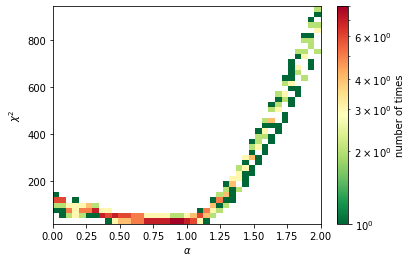

In [26]:
alphas_iter2 = np.concatenate(alphas_iter)  #As the simulation takes long, the plot is made separately so one can change the plot without having to simulate everything again
chisqs_iter2 = np.concatenate(chisqs_iter)


fig, ax = plt.subplots()
h = ax.hist2d(alphas_iter2, chisqs_iter2, bins=41, norm = colors.LogNorm(), cmap = "RdYlGn_r")
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$\chi^2$')
fig.colorbar(h[3], ax=ax, label="number of times")

After that, if needed we can do the same again with more $\alpha$ values between 0.76 and 1.14

In [19]:
niter = 1
chisqs_iter = []
alphas_iter = []

for j in range(niter):
    my_generator = np.random.default_rng(j)
    Simbckg1 = my_generator.poisson(bckgmu)
    # Simbckg1 = Simbckg1.astype(float)
    # for i in range(len(Simbckg1)):
    #     if Simbckg1[i] == 0:
    #         Simbckg1[i] = bckgmu[i]
    Simbckg1_u = np.sqrt(Simbckg1)
    Simbckg5 = my_generator.poisson(5*bckgmu)/5
    # Simbckg5 = Simbckg5.astype(float)
    # for i in range(len(Simbckg5)):
    #     if Simbckg5[i] == 0:
    #         Simbckg5[i] = bckgmu[i]
    Simbckg5_u = np.sqrt(Simbckg5)

    N = my_generator.poisson(mu_vec_reco)

    # for i in range(len(N)):
    #     if N[i] == 0:
    #         N[i] = mu[i]
    N_u = np.sqrt(N)

    NpB = np.around(N + Simbckg1 - Simbckg5).astype(int)
    NpB_u = N_u + Simbckg1_u - Simbckg5_u

    dNdE_b = NpB[1:] / EffaA2[1:35] / Ebinsw[3:37] / time
    dNdE_b_u = NpB_u[1:] / EffaA2[1:35] / Ebinsw[3:37] / time

    SED = np.square(E[3:37]) * dNdE_b
    SED_u = np.square(E[3:37]) * dNdE_b_u

    chisqs = []
    alphas = np.arange(0.76,1.14,0.02)

    for i in range(19):
        alpha = alphas[i]
        print("alpha = ", alpha)
        dNdE2 = dNdE_b[4:] * np.exp(alpha*tau[7:37])
        dNdE2_u = dNdE_b_u[4:] * np.exp(alpha*tau[7:37])
        SED2 = np.square(E[7:37]) * dNdE2
        SED_u2 = np.square(E[7:37]) * dNdE2_u
        ydata = SED2
        xdata = E[7:37]
        knots = 5
        ydata_u = SED_u2
        initial_guess = np.array([5e-7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]) #phi_0, lam1, deltas (len(deltas)=knots-2))
        things = multiple_bpl_fit(initial_guess=initial_guess)
        chi2 = chisq(SED2, multiple_bpl(E[7:37], things.values), SED_u2)
        chisqs.append(chi2)
    alphas_iter.append(alphas)
    chisqs_iter.append(chisqs)
    print("\033[2;31;43m iteration {iter} of {niter} finished \033[0;0m".format(iter = j+1, niter = niter))


alpha =  0.76
<ValueView x0=5.196339451867576e-07 x1=0.0824204794548899 x2=-0.49692264674981496 x3=-0.27797201061436994 x4=-0.555927482426234 x5=0.0 x6=0.0 x7=0.0 x8=0.0 x9=0.0 x10=0.0>
<ErrorView x0=0.0 x1=0.0 x2=0.0 x3=0.0 x4=0.0 x5=0.0 x6=0.0 x7=0.0 x8=0.0 x9=0.0 x10=0.0>
alpha =  0.78
<ValueView x0=5.220245918859745e-07 x1=0.07811571923219972 x2=-0.4759768380180755 x3=-0.25842307318767266 x4=-0.5680092386874216 x5=0.0 x6=0.0 x7=0.0 x8=0.0 x9=0.0 x10=0.0>
<ErrorView x0=0.0 x1=0.0 x2=0.0 x3=0.0 x4=0.0 x5=0.0 x6=0.0 x7=0.0 x8=0.0 x9=0.0 x10=0.0>
alpha =  0.8
<ValueView x0=5.244253721673119e-07 x1=0.07381268169513887 x2=-0.45406798062038123 x3=-0.2372813253321746 x4=-0.5798580866573956 x5=0.0 x6=0.0 x7=0.0 x8=0.0 x9=0.0 x10=0.0>
<ErrorView x0=0.0 x1=0.0 x2=0.0 x3=0.0 x4=0.0 x5=0.0 x6=0.0 x7=0.0 x8=0.0 x9=0.0 x10=0.0>
alpha =  0.8200000000000001
<ValueView x0=5.268361973427605e-07 x1=0.06951191026706642 x2=-0.4310479176438255 x3=-0.214080509912654 x4=-0.5914800483392753 x5=0.0 x6=0.0 x7

And plot it again

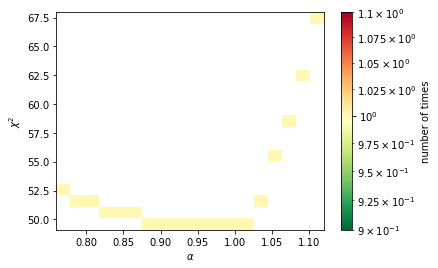

In [20]:
alphas_iter2 = np.concatenate(alphas_iter)
chisqs_iter2 = np.concatenate(chisqs_iter)


fig, ax = plt.subplots()
h = ax.hist2d(alphas_iter2, chisqs_iter2, bins=19, norm = colors.LogNorm(), cmap = "RdYlGn_r")
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$\chi^2$')
fig.colorbar(h[3], ax=ax, label="number of times")

In [21]:
# niter = 10
# mu = dNdEa[3:37] * EffaA2 * Ebinsw[3:37] * time 
# chisqs_iter = []
# alphas_iter = []

# if True:
#     my_generator = np.random.default_rng(106)
#     Simbckg1 = my_generator.poisson(bckgmu)
#     # Simbckg1 = Simbckg1.astype(float)
#     # for i in range(len(Simbckg1)):
#     #     if Simbckg1[i] == 0:
#     #         Simbckg1[i] = bckgmu[i]
#     Simbckg1_u = np.sqrt(Simbckg1)
#     Simbckg5 = my_generator.poisson(5*bckgmu)/5
#     # Simbckg5 = Simbckg5.astype(float)
#     # for i in range(len(Simbckg5)):
#     #     if Simbckg5[i] == 0:
#     #         Simbckg5[i] = bckgmu[i]
#     Simbckg5_u = np.sqrt(Simbckg5)

#     N = my_generator.poisson(mu)

#     # for i in range(len(N)):
#     #     if N[i] == 0:
#     #         N[i] = mu[i]
#     N_u = np.sqrt(N)
#     dNdE_p = dNdEa[3:37] * N/mu
#     dNdE_p_u = dNdEa[3:37] * 1/np.sqrt(N)

#     Simbckg = (Simbckg1 - Simbckg5) / EffaA2 / Ebinsw[3:37] / time
#     Simbckg_u = (Simbckg1_u + Simbckg5_u) / EffaA2 / Ebinsw[3:37] / time


#     dNdE_b = dNdE_p + Simbckg
#     dNdE_b_u = dNdE_p_u + Simbckg_u

#     SED = np.square(E[3:37]) * dNdE_b
#     SED_u = np.square(E[3:37]) * dNdE_b_u

#     chisqs = []
#     alphas = np.arange(0.76,1.14,0.02)

#     for i in range(19):
#         alpha = alphas[i]
#         dNdE2 = dNdE_b * np.exp(alpha*tau[3:37])
#         dNdE2_u = dNdE_b_u * np.exp(alpha*tau[3:37])
#         SED2 = np.square(E[3:37]) * dNdE2
#         SED_u2 = np.square(E[3:37]) * dNdE2_u
#         ydata = SED2
#         xdata = E[3:37]
#         knots =5
#         ydata_u = SED_u2
#         initial_guess = np.array([5e-7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]) #phi_0, lam1, deltas (len(deltas)=knots-2))
#         things = multiple_bpl_fit(initial_guess=initial_guess)
#         chi2 = chisq(SED2, multiple_bpl(E[3:37], things.values), SED_u2)
#         chisqs.append(chi2)
#     alphas_iter.append(alphas)
#     chisqs_iter.append(chisqs)
#     print("\033[2;31;43m iteration {iter} of {niter} finished \033[0;0m".format(iter = j+1, niter = niter))

# plt.plot(alphas, chisqs, 'o')
# plt.yscale('log')
# plt.xlabel(r'$\alpha$')
# plt.ylabel(r'$\chi^2$')
# plt.show()